In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'skirmantevaisnoraite'

# username from the json file

os.environ['KAGGLE_KEY'] = "0b6de90c38bbcf5902061c51887a53b4"

# key from the json file

In [ ]:
!kaggle datasets download -d agrigorev/clothing-dataset-full

100% 6.49G/6.50G [00:30<00:00, 252MB/s]
100% 6.50G/6.50G [00:30<00:00, 232MB/s]


In [ ]:
!cp clothing-dataset-full.zip drive/MyDrive/projectData.zip

In [ ]:
!unzip clothing-dataset-full.zip > /dev/null

In [6]:
import pandas as pd
img_csv = pd.read_csv('images.csv', sep=",")
img_csv

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [7]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [8]:
columns_to_exclude = ['Not sure', 'Skip', 'Blouse', 'Top', 'Undershirt', 
                      'Blazer', 'Hoodie', 'Body', 'Other', 'Polo', 'Hat']

for i in columns_to_exclude:
  img_csv = img_csv[img_csv['label'] != i]

len(img_csv)

4343

In [9]:
img_csv['label'].nunique()

9

In [10]:
img_csv['label'].unique()

array(['T-Shirt', 'Shoes', 'Shorts', 'Shirt', 'Pants', 'Skirt', 'Outwear',
       'Dress', 'Longsleeve'], dtype=object)

In [11]:
img_csv['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Skirt          155
Name: label, dtype: int64

[Text(0, 0, 'T-Shirt'),
 Text(1, 0, 'Shoes'),
 Text(2, 0, 'Shorts'),
 Text(3, 0, 'Shirt'),
 Text(4, 0, 'Pants'),
 Text(5, 0, 'Skirt'),
 Text(6, 0, 'Outwear'),
 Text(7, 0, 'Dress'),
 Text(8, 0, 'Longsleeve')]

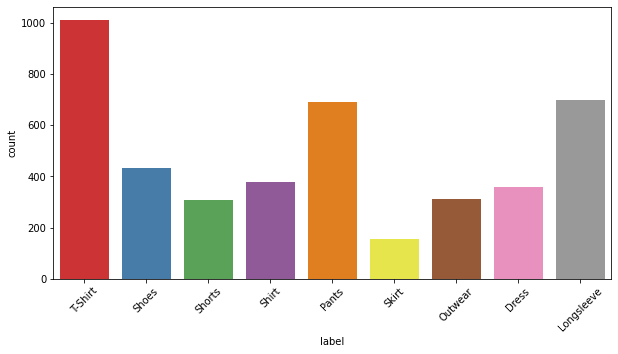

In [12]:
import seaborn as sns

plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=img_csv,
    x='label',
    palette='Set1')
# chart = sns.histplot(data=img_csv, x="label")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [13]:
img_csv['image'] = img_csv['image']+'.jpg'
img_csv = img_csv[['image', 'label']]

In [14]:
img_csv['image']

1       ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg
3       ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg
4       3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg
5       5d3a1404-697f-479f-9090-c1ecd0413d27.jpg
6       b0c03127-9dfb-4573-8934-1958396937bf.jpg
                          ...                   
5397    3855ea22-5e7f-411f-b1fa-6db27a676c06.jpg
5398    dfd4079d-967b-4b3e-8574-fbac11b58103.jpg
5400    5379356a-40ee-4890-b416-2336a7d84061.jpg
5401    65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg
5402    32b99302-cec7-4dec-adfa-3d4029674209.jpg
Name: image, Length: 4343, dtype: object

In [15]:
# import os

# failed = [
#     'images_compressed/c79626da-ec15-4905-9980-9cba60b36c4f.jpg',
#     'images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg',
#     'images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg',
#     'images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg',
#     'images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
#     'images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
#     'images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg',
#     'images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']


# for i in failed:
#    os.remove(i)

FileNotFoundError: ignored

In [16]:
img_csv = img_csv[img_csv['image'] != 'c79626da-ec15-4905-9980-9cba60b36c4f.jpg' ]
img_csv = img_csv[img_csv['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg' ]
img_csv = img_csv[img_csv['image'] != 'b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg' ]
img_csv = img_csv[img_csv['image'] != '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg' ]
img_csv = img_csv[img_csv['image'] != 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg' ]
img_csv = img_csv[img_csv['image'] != 'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg' ]
img_csv = img_csv[img_csv['image'] != '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg' ]
img_csv = img_csv[img_csv['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg' ]


len(img_csv)

4343

In [ ]:
# model = Img2Vec()
model = ResNet50(weights='imagenet', include_top=False,pooling='avg')

def return_image_embedding(model,img_path):
    img_path = f'images_compressed/{img_path}'
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
images_path = os.listdir('images_compressed/')
train_embeddings = pd.DataFrame()
for curr_img in tqdm(images_path):
    curr_df = return_image_embedding(model,curr_img)
    curr_df['image'] = curr_img
    train_embeddings = pd.concat([train_embeddings,curr_df],ignore_index=True)

In [18]:
from pathlib import Path  
filepath = Path('/content/train.csv')
train_embeddings.to_csv(filepath)

NameError: ignored

In [20]:
train_embeddings = pd.read_csv('drive/MyDrive/baigiamasis_darbas/train.csv')

train_embeddings = train_embeddings[train_embeddings['image'] != 'c79626da-ec15-4905-9980-9cba60b36c4f.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'c79626da-ec15-4905-9980-9cba60b36c4f.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'be5abec7-c658-4249-a15c-629557cc7441.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'ed484135-7bf9-4734-8323-d2f3b3d640fa.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '72239b49-3abe-42aa-b4fb-b39436becefb.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '8d9bc810-e146-4160-aeeb-47a5e131c56e.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'fe94de4f-958b-4a4f-a8d9-37748a70717d.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '8634bf59-371c-41d6-a7b2-b7592b2b2482.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '0197156f-b604-49bc-93ae-43ba0b8e2cd8.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'eaae2224-e417-465c-bd7a-60feeb33a864.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '9ef2b0b2-bf6f-4544-83eb-b69f785561c6.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '6a06dfe2-5e0f-4e2f-875d-56f159de38ab.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '6388d73a-66b0-4c68-9a3b-2a1a71d1df6c.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'b2ee19d6-93f1-4688-9545-d265887f226f.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '97d79060-78c0-4111-af1b-57d1475aa0f2.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '4bb006b8-1b11-443d-abb6-62b38a6228fc.jpg']

In [22]:
import pandas as pd
pd.options.mode.chained_assignment = None 
image_to_delete = []
train_embeddings['True_label'] = None

for i in train_embeddings.index:
  image = train_embeddings['image'][i]
  find_in_csv = img_csv[img_csv['image'] == image].index
  try:
    if find_in_csv[0] != 0:
      index_N = img_csv[img_csv['image']==image].index
      train_embeddings['True_label'][i] = img_csv['label'][index_N[0]]
  except Exception as e:
    image_to_delete.append(image)
    train_embeddings['True_label'][i] = None

In [23]:
train_embeddings = filter_rows_by_values(train_embeddings, 'image', image_to_delete)

In [24]:
len(image_to_delete)
# len(train_embeddings)

1399

In [ ]:
print(model.summary())

In [ ]:
test_list = os.listdir('/content/Test_df.xlsx')
test_list

In [25]:
test_df = pd.read_excel('/content/drive/MyDrive/baigiamasis_darbas/Test_df.xlsx')

embedding

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import os
from matplotlib import pyplot as plt
%matplotlib inline


def return_image_embedding(model,img_path):
    img = image.load_img(f'drive/MyDrive/baigiamasis_darbas/test/{img_path}', target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
images_path = os.listdir('drive/MyDrive/baigiamasis_darbas/test/')
test_embeddings = pd.DataFrame()
for curr_img in tqdm(images_path):
    curr_df = return_image_embedding(model,curr_img)
    curr_df['image'] = curr_img
    test_embeddings = pd.concat([test_embeddings,curr_df],ignore_index=True)


In [ ]:
test_embeddings.to_csv('drive/MyDrive/baigiamasis_darbas/test.csv')

In [28]:
test_embeddings = pd.read_csv('/content/drive/MyDrive/baigiamasis_darbas/test.csv')

In [29]:
train_embeddings.drop(['Unnamed: 0'], axis=1)
len(train_embeddings)

4342

cosine similarity

In [30]:
from joblib import Memory
def get_similar_items_sklearn(embedding_test: np.array, embedding_train: np.array, n_neighbours=20, save=False, weights='distance'): 
  nbrs = NearestNeighbors( n_neighbors=n_neighbours, algorithm="brute", metric="cosine", n_jobs=-1 ).fit(embedding_train) 
  if save: 
    joblib.dump(nbrs, "nearestNeighbors_model.pkl") 
  return nbrs.kneighbors(embedding_test, 2, return_distance=True),nbrs

In [31]:
embedding_test = test_embeddings.drop(['image', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [32]:
embedding_train = train_embeddings.drop(['image', 'Unnamed: 0','True_label'], axis=1)

In [34]:
distances_between_photos, nbrs = get_similar_items_sklearn(embedding_test, embedding_train)

In [36]:
distances, neighbours = zip(distances_between_photos)

import numpy as np 

distances_list =[]
for i in distances:
  for n in i:
    distances_list.append(n)

neighbours_list=[]
for i in neighbours:
  for n in i:
    neighbours_list.append(n)  

df_neigbours_distances = pd.DataFrame({'distances':np.array(distances_list).reshape([len(embedding_test), -1]).tolist(), 'neighbours':np.array(neighbours_list).reshape([len(embedding_test), -1]).tolist()}) 
df_neigbours_distances

,distances,neighbours
0,"[0.39538191096168296, 0.39851431963412365]","[3794, 2769]"
1,"[0.2981776484166292, 0.3173679178209543]","[4129, 3683]"
2,"[0.3776504399721412, 0.3817987286492235]","[174, 3993]"
3,"[0.3070929714651077, 0.3339504090948603]","[4129, 2253]"
4,"[0.17975396135231225, 0.20539139558282116]","[2404, 1225]"
5,"[0.1925319368947045, 0.20053522719528583]","[2700, 3932]"
6,"[0.1463555582415118, 0.15630077322954772]","[2549, 1225]"
7,"[0.11961007590726802, 0.15252956606450552]","[2700, 4154]"
8,"[0.228711073812206, 0.24402631850720125]","[3000, 1290]"
9,"[0.23662416388494223, 0.24454247598161782]","[4154, 1069]"


In [37]:
last_df = pd.concat([df_neigbours_distances, test_embeddings['image']], ignore_index=True, axis=1)

# New section

# New section

In [38]:
similars = []

for i in last_df[1].values:
  neighbour_1 = train_embeddings.iloc[i[0]]['image']
  neighbour_2 = train_embeddings.iloc[i[1]]['image']
  similars.append([neighbour_1, neighbour_2])

similars = pd.DataFrame(similars)

In [39]:
similar_photos = pd.concat([last_df, similars],ignore_index=True, axis=1)

In [40]:
similar_photos = similar_photos.rename(columns={0:'distances', 1:'neighbours', 2:'test_list', 3:'neighbour_1', 4:'neighbour_2'})

In [41]:
import cv2
import matplotlib.pyplot as plt 

def show_img(img_path):
    print(img_path)
    im = cv2.imread(img_path)
    im = cv2.resize(im, (244, 244))
    plt.axis('off')
    plt.imshow(im[:,:,::-1])
    plt.title(img_path)
    plt.show()

drive/MyDrive/baigiamasis_darbas/test/tshitrt.jpg


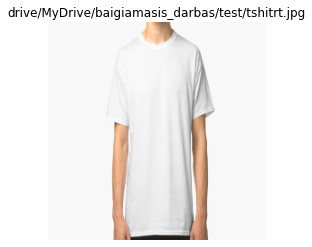

/content/images_original/18d2f018-1094-44f5-b047-e03518ac12c6.jpg


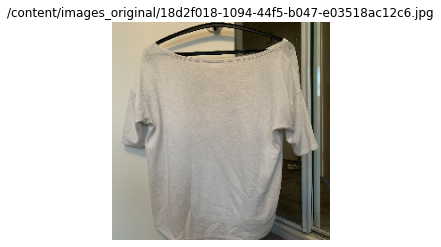

/content/images_original/4508a5a2-b4ac-40b7-b89b-3ad695375ea2.jpg


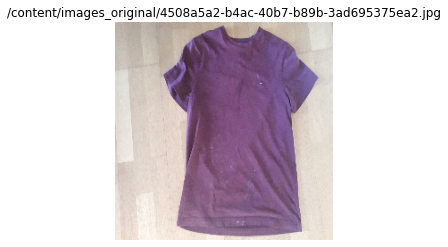

drive/MyDrive/baigiamasis_darbas/test/tshirt123.jpg


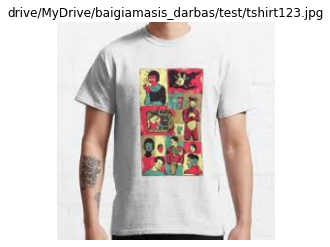

/content/images_original/7de33c36-7554-474d-84ce-7f7281a5278f.jpg


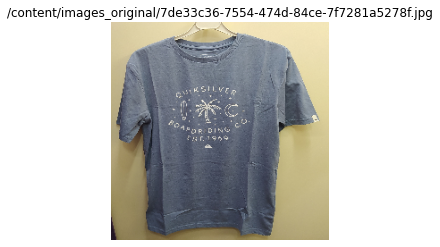

/content/images_original/09cd8fdf-bbe9-4908-8f54-f399bc635c9b.jpg


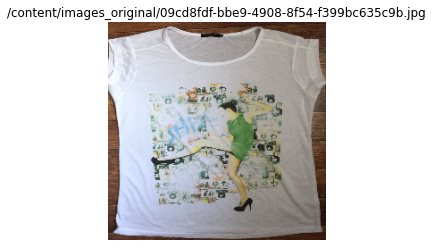

drive/MyDrive/baigiamasis_darbas/test/tshirts.jpg


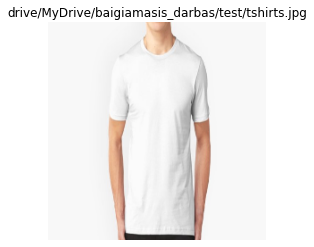

/content/images_original/230ee7f3-a206-4804-9c23-8b5bda052140.jpg


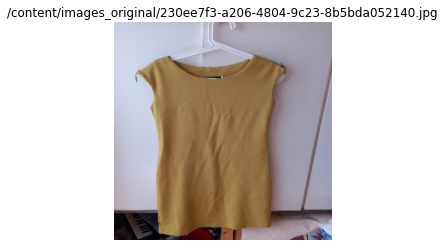

/content/images_original/43b09cd1-a863-40ff-91a4-6b33e39db7b4.jpg


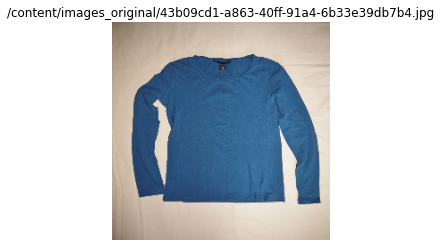

In [42]:
counter = 0
for test, n_1, n_2 in zip(similar_photos['test_list'],similar_photos['neighbour_1'], similar_photos['neighbour_2']):
  test_img_path = 'drive/MyDrive/baigiamasis_darbas/test/'+str(test)
  show_img(test_img_path)
  train_img_path = '/content/images_original/'+str(n_1)
  show_img(train_img_path)
  train_img_path = '/content/images_original/'+str(n_2)
  show_img(train_img_path)
  counter = counter + 1
  if counter == 3:
    break

In [43]:
from sklearn.metrics import confusion_matrix

with_labels = pd.merge(
    test_df,
    similar_photos,
    how="inner",left_on='test_list',
    right_on='test_list')
with_labels['true_label'] = with_labels['label']
with_labels.drop(columns='label')

with_labels['nearest_neighbour'] = None
for i in similar_photos.index:
  if i >= len(similar_photos) -1:
    break
  distances = similar_photos['distances'][i]
  if distances[0]> distances[1]:
    with_labels['nearest_neighbour'][i] = with_labels['neighbour_2'][i]
  else:
    with_labels['nearest_neighbour'][i] = with_labels['neighbour_1'][i]

not_found_neighbours = []
with_labels['Predicted_label'] = None
for i in similar_photos.index:
  if i >= len(similar_photos) -1:
    break
  nearest_neighbour = with_labels['nearest_neighbour'][i]
  index_N = img_csv[img_csv['image']==nearest_neighbour].index
  try:
    with_labels['Predicted_label'][i] = img_csv['label'][index_N[0]]
  except Exception as e:
    not_found_neighbours.append(nearest_neighbour)
    print(nearest_neighbour)


In [44]:
cmx = confusion_matrix(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist(), labels=with_labels['true_label'].unique())
df = pd.DataFrame(cmx, columns=with_labels['true_label'].unique(), index=with_labels['true_label'].unique())
df.columns.name = 'prediction'
df

prediction,Dress,Shoes,Pants,Longsleeve,Shorts,T-Shirt,Skirt,Other,Outwear
Dress,3,0,0,1,0,1,0,0,0
Shoes,0,6,0,0,0,0,0,0,0
Pants,1,0,10,0,0,0,0,0,0
Longsleeve,1,0,0,0,0,1,0,0,0
Shorts,0,0,2,0,3,1,0,0,0
T-Shirt,6,0,4,2,0,8,0,0,0
Skirt,0,0,1,0,0,0,1,0,0
Other,1,0,0,0,0,0,0,0,0
Outwear,0,0,0,0,0,0,0,0,1


In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score

classif = classification_report(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist())

print(classif)

accuracy_score(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist())

precision_score(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist(), average='macro')

              precision    recall  f1-score   support

       Dress       0.25      0.60      0.35         5
  Longsleeve       0.00      0.00      0.00         2
       Other       0.00      0.00      0.00         1
     Outwear       1.00      1.00      1.00         1
       Pants       0.59      0.91      0.71        11
       Shoes       1.00      1.00      1.00         6
      Shorts       1.00      0.50      0.67         6
       Skirt       1.00      0.50      0.67         2
     T-Shirt       0.73      0.40      0.52        20

    accuracy                           0.59        54
   macro avg       0.62      0.55      0.55        54
weighted avg       0.69      0.59      0.60        54



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

0.618389780154486

In [46]:
#Grid Search
from sklearn.model_selection import GridSearchCV

n_neighbors = [100, 3, 25, 1]
for n in n_neighbors:
  nbrs1 = NearestNeighbors(n_neighbors=n, algorithm="ball_tree", metric="minkowski", n_jobs=-1).fit(embedding_train) 
  predictions = nbrs1.kneighbors(embedding_test, 1, return_distance=True)
  print(predictions)
  df_predictions = pd.DataFrame({'distances':np.array(predictions[0]).reshape([len(embedding_test),-1]).tolist(), 
                                 'neighbours':np.array(predictions[1]).reshape([len(embedding_test),-1]).tolist()}) 
  predicrions_df = pd.concat([df_predictions, test_embeddings['image']],ignore_index=True, axis=1)
  predicrions_df = predicrions_df.rename(columns={2: 'test_list'})
  closest = []
  for i in last_df[1].values:
    neighbour_1 = train_embeddings.iloc[i[0]]['image']
    closest.append(neighbour_1)
  predicrions_df['neighbor'] = closest
  after_grid = pd.merge(
    test_df,
    predicrions_df,
    how="inner",left_on='test_list',
    right_on='test_list')
  after_grid['true_label'] = after_grid['label']
  after_grid.drop(columns='label')
  after_grid['Predicted_label'] = None

  for i in predicrions_df.index:
    if i >= len(test_embeddings)-1:
      break
    neighbor = after_grid['neighbor'][i]
    index_N = img_csv[img_csv['image']==neighbor].index
    try:
      after_grid['Predicted_label'][i] = img_csv['label'][index_N[0]]
    except Exception as e:
      print(e)
  accuraccy = accuracy_score(after_grid['true_label'].tolist(), after_grid['Predicted_label'].tolist())
  print(accuraccy, n)

(array([[30.6911417 ],
       [30.93159305],
       [30.44454247],
       [30.21541187],
       [24.07668202],
       [25.37414865],
       [27.51104254],
       [23.39328126],
       [29.11262358],
       [28.47505754],
       [31.37969515],
       [35.81672535],
       [37.28357624],
       [33.76127336],
       [28.98653333],
       [32.89240889],
       [22.15188383],
       [25.84890587],
       [27.78043272],
       [43.10679207],
       [28.2252172 ],
       [30.49637831],
       [31.84554323],
       [33.48695944],
       [31.51220862],
       [28.73484615],
       [31.36922607],
       [27.06748249],
       [31.50522347],
       [30.36952457],
       [29.34778092],
       [29.84738849],
       [33.34343307],
       [29.62660354],
       [32.05704421],
       [29.32014306],
       [36.79694893],
       [23.8053265 ],
       [31.35099837],
       [29.70526508],
       [33.48695944],
       [25.68208972],
       [25.70632958],
       [30.1331893 ],
       [23.52817833],
       [2

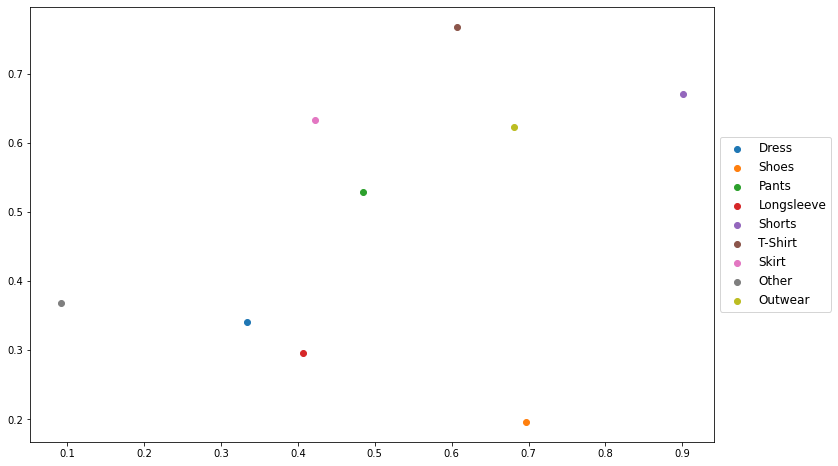

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Random 2D points to make scatter plot
x = [np.random.random() for i in range(len(with_labels['true_label'].unique()))]
y = [np.random.random() for i in range(len(with_labels['true_label'].unique()))]

fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(111)



colors = plt.cm.rainbow(np.linspace(0, 1, len(with_labels['true_label'].unique())))

for i, j, name in zip(x, y, with_labels['true_label'].unique()):
    ax.scatter(i, j, label=name)

fig.subplots_adjust(right=0.6)  # This is needed so that the legend is not cut out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.show()


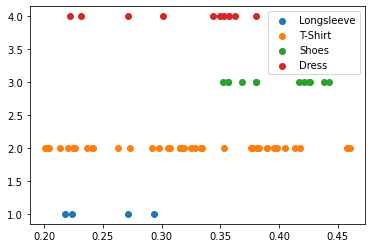

In [48]:
import matplotlib.pyplot as plt

y3 =  2*len(with_labels[with_labels['label']=='Dress']['distances'].tolist())*[4]
x3 = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Dress']['distances'].tolist()))
y2 =  2*len(with_labels[with_labels['label']=='Shoes']['distances'].tolist())*[3]
x2 = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Shoes']['distances'].tolist()))
y1 =  2*len(with_labels[with_labels['label']=='T-Shirt']['distances'].tolist())*[2]
x1 = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='T-Shirt']['distances'].tolist()))
y =  2*len(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist())*[1]
x = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist()))

plt.scatter(x, y, label='Longsleeve')
plt.scatter(x1, y1, label='T-Shirt')
plt.scatter(x2, y2, label='Shoes')
plt.scatter(x3, y3, label='Dress')
plt.legend()
plt.show()

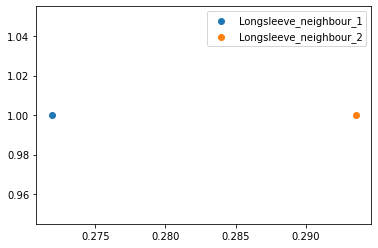

In [49]:
import matplotlib.pyplot as plt
y =  2*len(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist())*[1]
x = np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist()))
plt.scatter(x[0], y[0], label='Longsleeve_neighbour_1')
plt.scatter(x[1], y[1], label='Longsleeve_neighbour_2')
plt.legend()
plt.show()